In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import math
from scipy.stats.mstats import zscore
import statistics
from semopy import Model
from semopy import Optimizer
from semopy.stats import calc_gfi
from semopy.stats import calc_chi2
import semopy

In [3]:
df_study_3 = pd.read_csv('../data/study4_olr_formatted.csv', delimiter=',')

#get emotion concepts split on pleasant
emo_concepts_regression = [i.split('Pleas')[0] for i in df_study_3.columns if len(i.split('Pleas'))>1]

num_emo_concepts = len(emo_concepts_regression)
emotion_index = np.arange(0,13)
emotions_n_indexes = dict(zip(emo_concepts_regression,emotion_index))

## Frequentist Regressions

In [4]:
def TwoLevelModel(emotion, valuation_dimensions):
    
    mod = """ {emotion}Ideal ~ {emotion}Good + {emotion}Pleasant
              {emotion}Actual ~ {emotion}Ideal""".format(emotion=emotion)
    model = Model(mod)
    
    columns = [emotion + valuation for valuation in valuation_dimensions]
    data_z = zscore(df_study_3[columns])
    model.load_dataset(pd.DataFrame(columns=columns,data=data_z))

    opt = Optimizer(model)
    objective_function_value = opt.optimize()
    
    return semopy.gather_statistics(opt)

def FlatModel(emotion, valuation_dimensions):
    
    mod = """ {emotion}Actual ~ {emotion}Ideal + {emotion}Good + {emotion}Pleasant""".format(emotion=emotion)
    model = Model(mod)
    
    columns = [emotion + valuation for valuation in valuation_dimensions]
    data_z = zscore(df_study_3[columns])
    model.load_dataset(pd.DataFrame(columns=columns,data=data_z))

    opt = Optimizer(model)
    objective_function_value = opt.optimize()
    
    return semopy.gather_statistics(opt)

def CreateModelDf(emotions, ModelDefinition):
    P_Val_Const,P_Val_Good,P_Val_Ideal,P_Val_Pleasant = [], [], [], []
    B_Val_Const, B_Val_Good, B_Val_Ideal, B_Val_Pleasant =  [], [], [], []
    rmsea, gfi, chi2, chi2_p = [],[],[],[]
    for emotion in emotions:
        sem_summary = ModelDefinition(emotion,["Ideal","Good","Pleasant","Actual"])
        P_Val_Ideal.append(sem_summary.params[0].pvalue)
        P_Val_Good.append(sem_summary.params[1].pvalue)
        P_Val_Pleasant.append(sem_summary.params[2].pvalue)
        B_Val_Ideal.append(sem_summary.params[0].value)
        B_Val_Good.append(sem_summary.params[1].value)
        B_Val_Pleasant.append(sem_summary.params[2].value)
        gfi.append(sem_summary.gfi)
        rmsea.append(sem_summary.rmsea)
        chi2.append(sem_summary.chi2[0])
        chi2_p.append(sem_summary.chi2[1])

    return pd.DataFrame({'emotion':emo_concepts_regression,
                                    'P_Val_Good':P_Val_Good,
                                    'P_Val_Ideal':P_Val_Ideal,
                                    'P_Val_Pleasant':P_Val_Pleasant,
                                    'B_Val_Good':B_Val_Good,
                                    'B_Val_Ideal':B_Val_Ideal,
                                    'B_Val_Pleasant':B_Val_Pleasant,
                                    'rmsea':rmsea,
                                    'gfi':gfi,
                                    'chi2':chi2,
                                    'chi2_p':chi2_p})
TwoLevelModeldf = CreateModelDf(emo_concepts_regression, TwoLevelModel)
FlatModelDf = CreateModelDf(emo_concepts_regression, FlatModel)
emo_concepts_regression

['Shame',
 'Fear',
 'Calm',
 'Jealousy',
 'Miserable',
 'Lust',
 'Disgust',
 'Guilt',
 'Happy',
 'Love',
 'Pride',
 'Excitement',
 'Sadness']

In [5]:
def CorrModel(emotion, valuation_dimensions):
    
    columns = [emotion + valuation for valuation in valuation_dimensions]
    data_z = zscore(df_study_3[columns])
    return pd.DataFrame(data=data_z, columns=columns).corr()
    
CorrModel("Disgust",["Ideal","Good","Pleasant","Actual"])

,DisgustIdeal,DisgustGood,DisgustPleasant,DisgustActual
DisgustIdeal,1.000000,0.652381,0.828205,0.743707
DisgustGood,0.652381,1.000000,0.756903,0.594027
DisgustPleasant,0.828205,0.756903,1.000000,0.670139
DisgustActual,0.743707,0.594027,0.670139,1.000000


## Bayesian Models - Standardized and Melt Data

In [6]:
#"melt" data rather then being long with many columns make few columns with many rows
emotion_text,emotion_index = [], []
pleasant,actual,ideal,good = [], [],[], []
for i in range(len(df_study_3)):
    row = df_study_3.iloc[i]
   
    for emotion in emo_concepts_regression:
        emotion_ratings_cols = [column for column in df_study_3.columns if len(column.split(emotion))>1]
        good.append(row[emotion_ratings_cols[0]])
        pleasant.append(row[emotion_ratings_cols[1]])
        ideal.append(row[emotion_ratings_cols[2]])
        actual.append(row[emotion_ratings_cols[3]])
        emotion_text.append(emotion)
        emotion_index.append(emotions_n_indexes[emotion])
melted_df = pd.DataFrame({
    'emotion':emotion_text,
    'emotion_index':emotion_index,
    'Good':good,
    'Pleasant':pleasant,
    'Ideal':ideal,
    'Actual':actual
})

In [7]:
emotion_specific_score = melted_df.loc[melted_df['emotion_index']==0]
emotions_standardize = emotion_specific_score['emotion']
emotion_index_standardize = emotion_specific_score['emotion_index']
standardized_good_emotion_specific = zscore(emotion_specific_score['Good'])
standardized_pleasant_emotion_specific = zscore(emotion_specific_score['Pleasant'])
standardized_ideal_emotion_specific = zscore(emotion_specific_score['Ideal'])
standardized_actual_emotion_specific = zscore(emotion_specific_score['Actual'])

for i in range(1,13):
    emotion_specific_score = melted_df.loc[melted_df['emotion_index']==i]
    emotions_standardize=np.append(emotions_standardize, emotion_specific_score['emotion'])
    emotion_index_standardize=np.append(emotion_index_standardize,emotion_specific_score['emotion_index'])
    standardized_good_emotion_specific=np.append(standardized_good_emotion_specific,zscore(emotion_specific_score['Good']))
    standardized_pleasant_emotion_specific = np.append(standardized_pleasant_emotion_specific, zscore(emotion_specific_score['Pleasant']))
    standardized_ideal_emotion_specific = np.append(standardized_ideal_emotion_specific, zscore(emotion_specific_score['Ideal']))
    standardized_actual_emotion_specific = np.append(standardized_actual_emotion_specific,(zscore(emotion_specific_score['Actual'])))
    
    
standardized_melted_df = pd.DataFrame({
    'emotion':emotions_standardize,
    'emotion_index':emotion_index_standardize,
    'Good':standardized_good_emotion_specific,
    'Pleasant':standardized_pleasant_emotion_specific,
    'Ideal':standardized_ideal_emotion_specific,
    'Actual':standardized_actual_emotion_specific
})

std_emotion_index = standardized_melted_df['emotion_index']

## Bayes Linear Regressions

In [8]:
with pm.Model() as simple_desired: 
    
    emotion_index = standardized_melted_df['emotion_index']
    ideal = pm.Normal('ideal', mu=0, sd=1e5, shape=num_emo_concepts)
    
    b= pm.Normal('b', mu=0, sd=1e5, shape=num_emo_concepts)
    
    
    actual_est = ideal[emotion_index] * standardized_melted_df['Ideal'].values + b[emotion_index]
    
    # Model error
    eps = pm.Uniform('eps', upper=100, lower=0)
    
    actual_like = pm.Normal('actual_like', 
                            mu=actual_est,
                            sd=eps, 
                            observed=standardized_melted_df.Actual)

In [9]:
#with simple_desired:
#    simple_desired_trace = pm.sample(10000, cores=2)

In [10]:
#pm.save_trace(simple_desired_trace, directory="predict_actual_trace")
simple_desired_trace = pm.load_trace("predict_actual_trace", simple_desired)

In [11]:
with pm.Model() as desired_from_hedonic_good_model:
    emotion_index = standardized_melted_df['emotion_index']
    
    good = pm.Normal('good', mu=0, sd=1e5, shape=num_emo_concepts)
    
    
    pleasant = pm.Normal('pleasant', mu=0, sd=1e5, shape=num_emo_concepts)
    
    b = pm.Normal('b', mu=0, sd=1, shape=num_emo_concepts)
   
    ideal_est = good[emotion_index]*standardized_melted_df['Good'].values + pleasant[emotion_index]*standardized_melted_df['Pleasant'].values + b[emotion_index]
    
    # Model error
    eps = pm.HalfCauchy('eps', 5.)
    
    ideal_like = pm.Normal('ideal_like', 
                            mu=ideal_est,
                            sd=eps, 
                            observed=standardized_melted_df.Ideal)

In [12]:
# with desired_from_hedonic_good_model:
#     predict_desired_trace = pm.sample(10000, target_accept=.9, cores=2)
# pm.save_trace(predict_desired_trace, directory='predict_desired_trace', overwrite=True)
predict_desired_trace = pm.load_trace('predict_desired_trace', desired_from_hedonic_good_model)

In [12]:
with pm.Model() as flat_model_bayes:
    emotion_index = standardized_melted_df['emotion_index']
    
    good = pm.Normal('good', mu=0, sd=1e5, shape=num_emo_concepts)
    
    ideal = pm.Normal('ideal', mu=0, sd=1e5, shape=num_emo_concepts)
    
    pleasant = pm.Normal('pleasant', mu=0, sd=1e5, shape=num_emo_concepts)
    
    b = pm.Normal('b', mu=0, sd=1, shape=num_emo_concepts)
   
    actual_est = ideal[emotion_index] * standardized_melted_df.Ideal.values + good[emotion_index]*standardized_melted_df['Good'].values + pleasant[emotion_index]*standardized_melted_df['Pleasant'].values + b[emotion_index]
    
    # Model error
    eps = pm.HalfCauchy('eps', 5.)
    
    ideal_like = pm.Normal('actual_like', 
                            mu=actual_est,
                            sd=eps, 
                            observed=standardized_melted_df.Actual)

In [13]:
with flat_model_bayes:
    #flat_model_trace = pm.sample(10000, target_accept=.9, cores=2)
    #pm.save_trace(flat_model_trace, directory='flat_model_trace', overwrite=True)


SyntaxError: unexpected EOF while parsing (<ipython-input-13-a465c897fc0a>, line 3)

In [16]:
##ok so we need to iterate through all the emoconcepts - then for each get statistics from 
def GetAllYLabelStrings(emotions, two_level_model_df):
    ylabel_strings = []
    for emotion in emotions:
        row = two_level_model_df.loc[two_level_model_df['emotion']==emotion]
        y_string = CreateYLabelString(emotion,
                                     row.chi2.values[0],
                                     row.chi2_p.values[0],
                                     row.rmsea.values[0])
        ylabel_strings.append(y_string)
    return ylabel_strings
def SelectPValString(p_value,stat="p"):
   
    if p_value<.001:
        return stat+"<.001"
    elif p_value<.01:
        return stat+"<.01"
    elif p_value<.05:
        return stat+"<.05"
    else:
        return stat+">.05"
    
def SelectRMSEAString(rmsea,stat='RMSEA'):
   
    if rmsea<.001:
        return stat+"<.001"
    elif rmsea<.01:
        return stat+"<.01"
    else:
        return " RMSEA: "+str(round(rmsea,2))
    
def p_val_max(p_val):
    rounded_up_p = math.floor(p_val*100)/100
    if rounded_up_p == 1:
        return .99
    return rounded_up_p
def CreateYLabelString(emotion, chi_squared, pval, rmsea):
    rounded_p = p_val_max(pval)
    chi_2 = r'$\chi^2$: ' + str(round(chi_squared,2))
    chi_2_p = " p>%.02f"%rounded_p
    rmsea_string = " \n" + SelectRMSEAString(rmsea)
    return emotion + "\n" + chi_2 + chi_2_p + rmsea_string
    
def CreateTextBoxString(bayes_samples, p_val):
    hpd = pm.stats.hdi(bayes_samples)
    rounded_up_p = math.ceil(hpd[0]*100)/100
    hpd_string = "hpd: " + "%.02f"%rounded_up_p + "," + "%.02f"%round(hpd[1],2) 
    starred ="*" if p_val<.05 else ""
    p_string = "\n" + SelectPValString(p_val) + starred
    return  hpd_string + p_string

def MakeIndividualPlot(ax, bayes_samples, b_val, p_val, hist_color, line_color,yticks):
    ax.set_xlim(-1,1)
    ax.set_ylim(0,6)
    text_string = CreateTextBoxString(bayes_samples,p_val)
    ax.text(-.95,5.8,text_string , fontsize=14, horizontalalignment='left',va='top')
    plot = ax.hist(bayes_samples,bins=30, color=hist_color, density=True)
    ax.axvline(0,linewidth=1, color=line_color)
    ax.axvline(b_val,linewidth=2,color=line_color,linestyle='--')
    ax.set_yticks(yticks)
    
def DrawPlotDiagram (ax, lw_1, lw_2, lw_3):
    ax.annotate("Hedonic", xy=(0.39, 0.49), xytext=(.1, .1),
                 arrowprops=dict(arrowstyle='->',linewidth=lw_1, mutation_scale=20),
                 bbox=dict(facecolor='none', edgecolor='black'))
    ax.annotate("Evaluative", xy=(0.39, 0.51), xytext=(.1, .89),
                 arrowprops=dict(arrowstyle='->',linewidth=lw_2,mutation_scale=20),
                bbox=dict(facecolor='none', edgecolor='black'))
    ax.annotate("Desired", xy=(0.8, 0.52), xytext=(.4, .5),
                 arrowprops=dict(arrowstyle='->',linewidth=lw_3,mutation_scale=20),
                bbox=dict(facecolor='none', edgecolor='black'))
    ax.annotate("  Emotion \nFrequency",xytext=(.81, .46), xy=(.8,.5),
                bbox=dict(facecolor='none', edgecolor='black'))
    ax.axis('off')
def DrawFlatDiagram(ax, lw_1, lw_2, lw_3):
    ax.annotate("Hedonic", xy=(0.58, 0.43), xytext=(.1, .05),
                 arrowprops=dict(arrowstyle='->',linewidth=lw_1, mutation_scale=20),
                 bbox=dict(facecolor='none', edgecolor='black'))
    ax.annotate("Evaluative", xy=(0.58, 0.59), xytext=(.1, .95),
                 arrowprops=dict(arrowstyle='->',linewidth=lw_2,mutation_scale=20),
                bbox=dict(facecolor='none', edgecolor='black'))
    ax.annotate("Desired", xy=(0.58, 0.51), xytext=(.1, .50),
                 arrowprops=dict(arrowstyle='->',linewidth=lw_3,mutation_scale=20),
                bbox=dict(facecolor='none', edgecolor='black'))
    ax.annotate("Emotion Frequency",xytext=(.6, .5), xy=(.6,.5),
                bbox=dict(facecolor='none', edgecolor='black'))
    ax.axis('off')

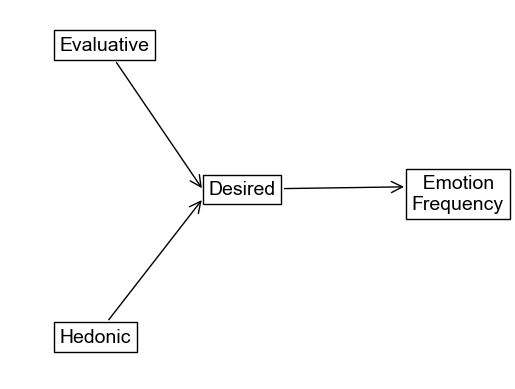

In [17]:
ax= plt.gca()
DrawPlotDiagram (ax, 1,1,1)

Lust
0.7353103341168422
-0.005860530020166821
Miserable
0.5906445924924214
0.3555279826762702
Excitement
0.5641514679008754
0.032038968374089795
Pride
0.481814979213573
0.25373941503576003
Calm
0.4297420716042358
0.264775564230624
Love
0.3674107614860399
0.30035054964705654
Jealousy
0.15136129557756672
0.6877929225169791
Happy
0.12412845016307188
0.3589480154942178
Guilt
0.10352986176559655
0.720513089079084
Shame
0.08308822325379202
0.7905206757900423
Disgust
0.05942158996559958
0.7830900763835504
Fear
0.04171359891893653
0.8548219357994623


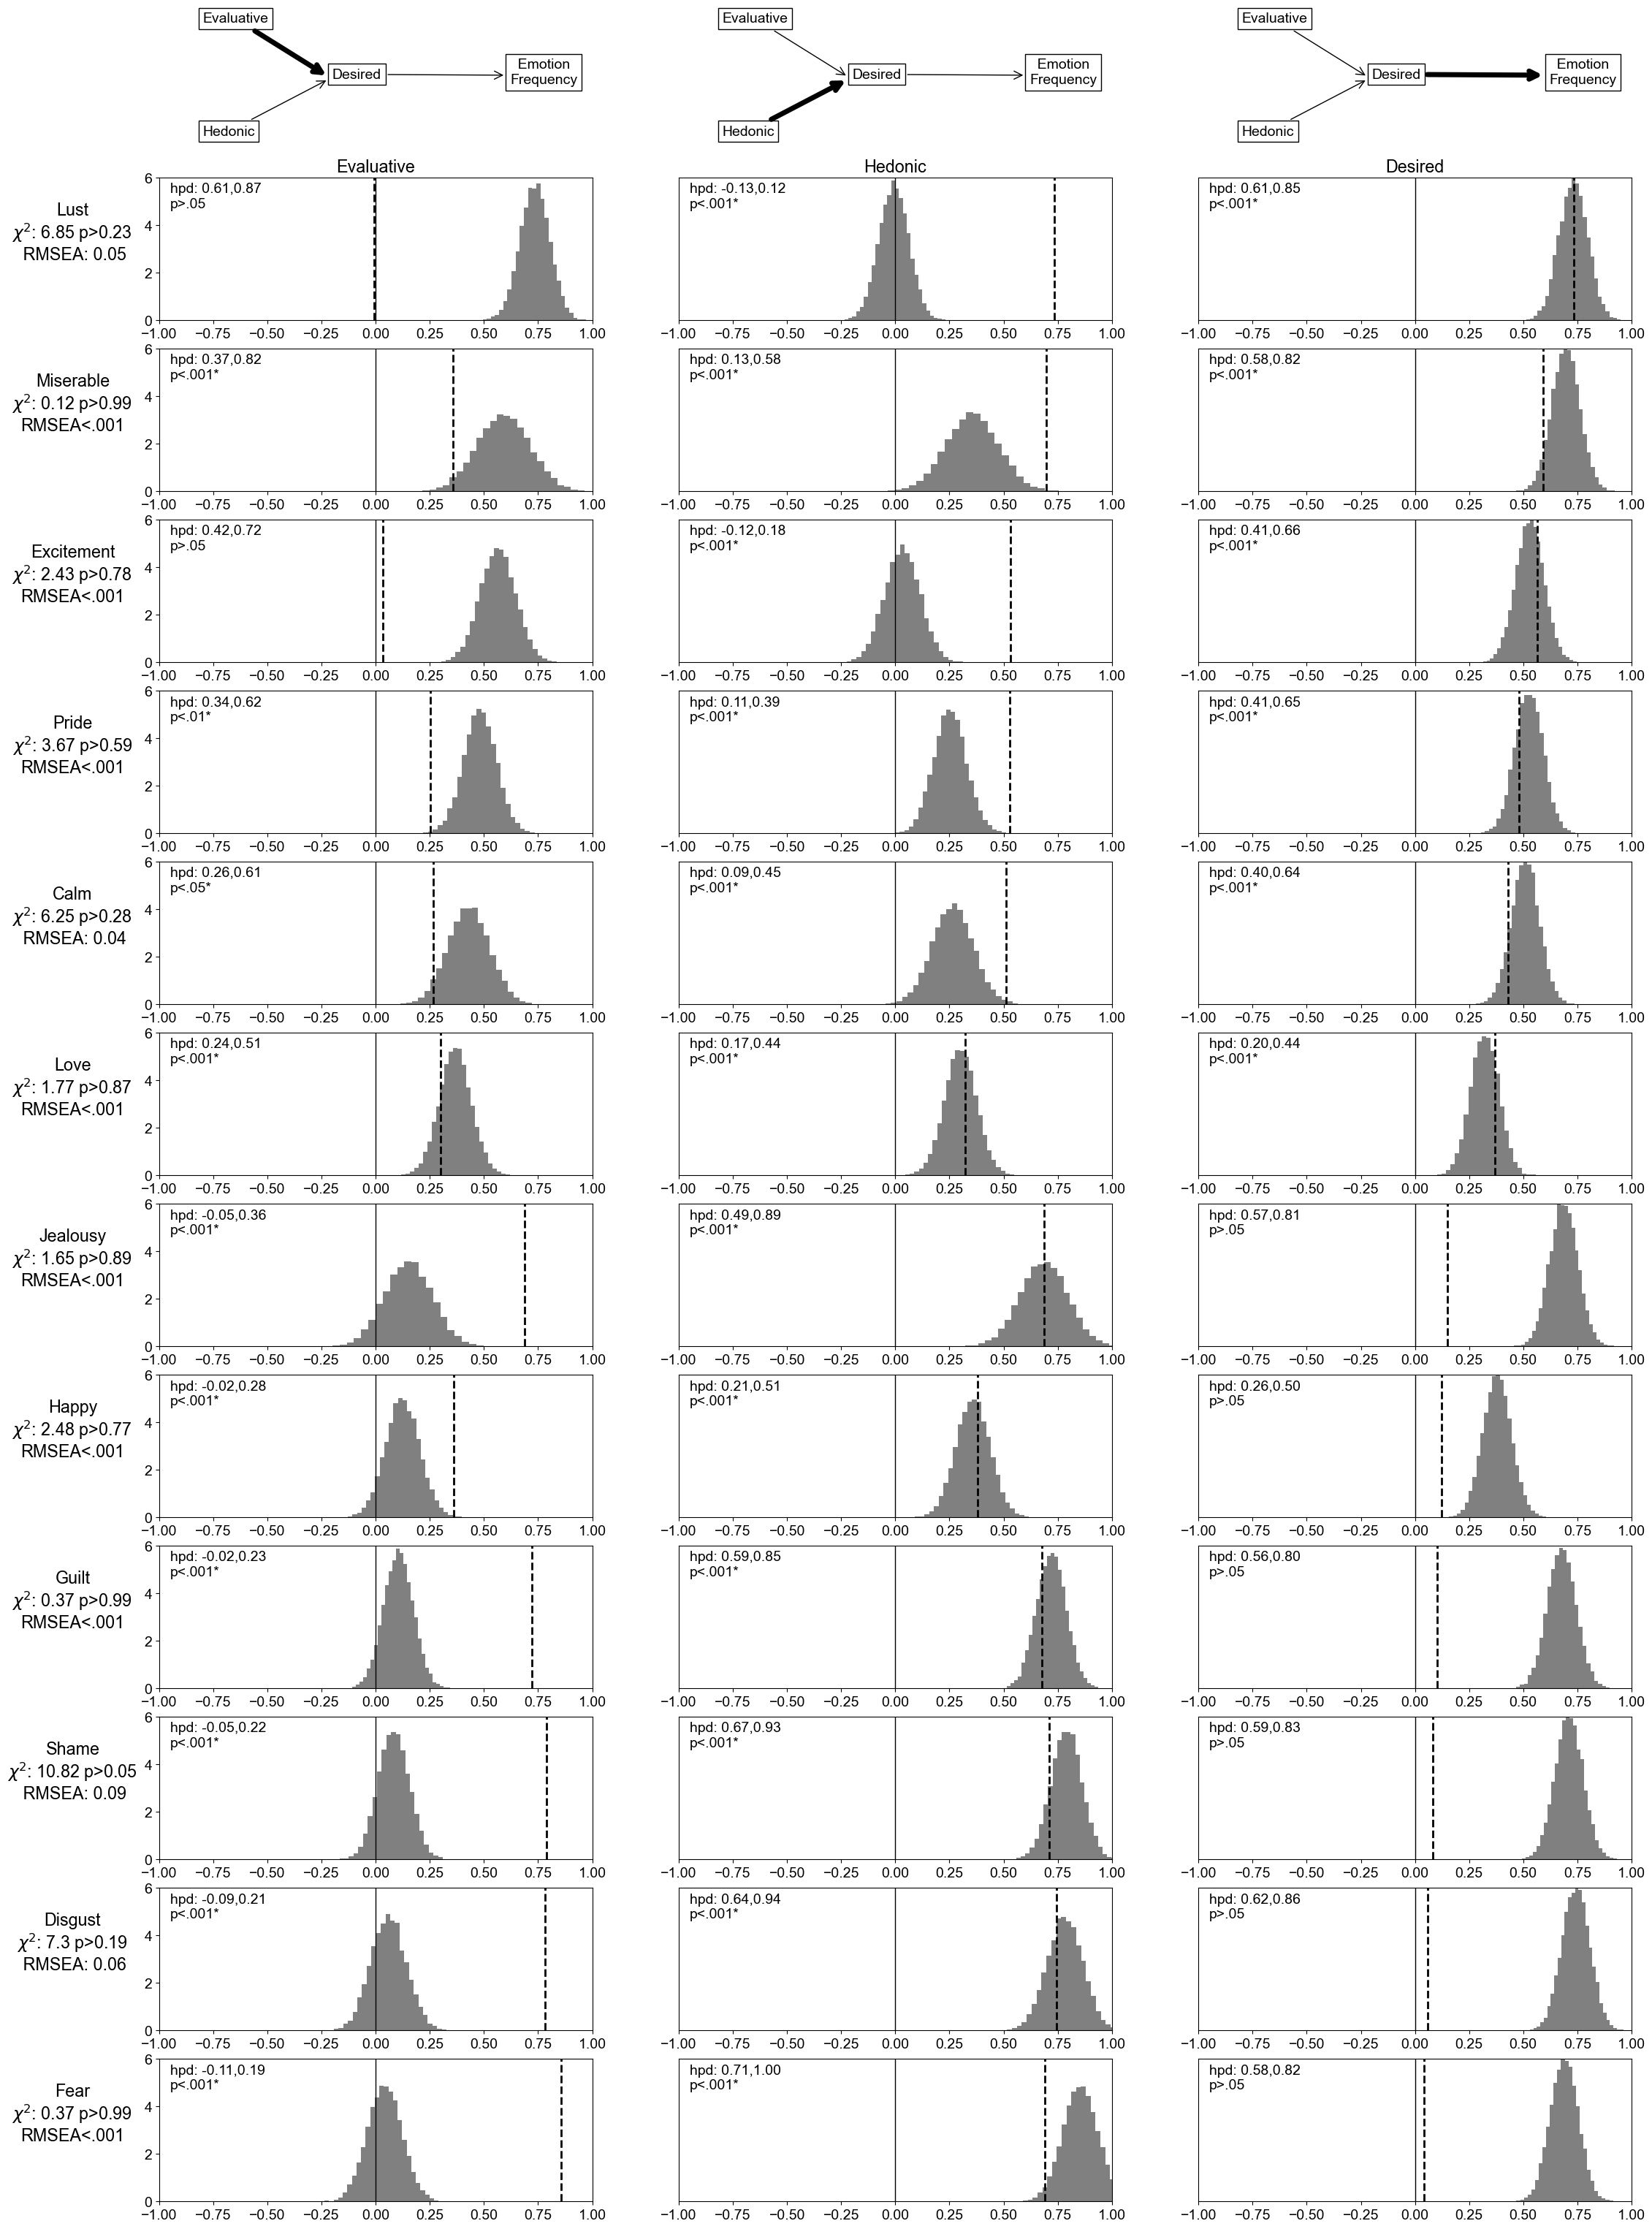

In [18]:
bayes_good_betas_means = [np.mean(predict_desired_trace['good'][:,i]) for i in range(len(emo_concepts_regression))]
sorted_index = pd.DataFrame(data={'means':bayes_good_betas_means}).sort_values('means', ascending=False).index.values
emotion_order_plot = np.array(emo_concepts_regression)[sorted_index]


plt.rcParams.update({'font.size': 14,
                    'font.family':'Arial'})

fig,axes =plt.subplots(13,3, figsize=(26,39))
valuation_columns = ['Evaluative','Hedonic','Desired']

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

for ax, col in zip(axes[1], valuation_columns):
    ax.set_title(col)

ylabel_strings = GetAllYLabelStrings(emotion_order_plot, TwoLevelModeldf)
for ax, label in zip(axes[1:,0], ylabel_strings):
    ax.set_ylabel(label, rotation=0, labelpad=10, size='large')
    ax.yaxis.set_label_coords(-0.2,.4)

line_color ='black'
hist_color = 'grey'

DrawPlotDiagram (axes[0,0], 1,5,1)
DrawPlotDiagram (axes[0,1], 5,1,1)
DrawPlotDiagram (axes[0,2], 1,1,5)


for idx in range(1,13):
    emotion_idx = sorted_index[idx-1]
    emotion = emo_concepts_regression[emotion_idx]
    
    row = TwoLevelModeldf.loc[TwoLevelModeldf['emotion']==emotion]
    
    beta_good= row.B_Val_Good.values[0]
    beta_good_p = row.P_Val_Good.values[0]
    beta_good_bayes = predict_desired_trace['good'][:,emotion_idx]
    print(emotion)
    print(np.mean(beta_good_bayes))
    print(beta_good)
    
    beta_pleasant = row.B_Val_Pleasant.values[0]
    beta_pleasant_p = row.P_Val_Pleasant.values[0]
    beta_pleasant_bayes = predict_desired_trace['pleasant'][:,emotion_idx]
    
    
    beta_ideal_p =row.P_Val_Ideal.values[0]
    beta_ideal = row.B_Val_Ideal.values[0]
    beta_ideal_bayes = simple_desired_trace['ideal'][:,emotion_idx]
    
    #good plot
    MakeIndividualPlot(axes[idx,0],
                       beta_good_bayes,
                       beta_good,
                      beta_good_p,
                      hist_color,
                      line_color,
                      [0,2,4,6])

    
    #pleasant plot
    MakeIndividualPlot(axes[idx,1],
                       beta_pleasant_bayes,
                       beta_pleasant,
                      beta_pleasant_p,
                      hist_color,
                      line_color,
                      [])
    
    #ideal plot
    MakeIndividualPlot(axes[idx,2],
                       beta_ideal_bayes,
                       beta_ideal,
                      beta_ideal_p,
                      hist_color,
                      line_color,
                      [])

    
#plt.savefig('Updated_Path_Fig.eps', dpi=1200)

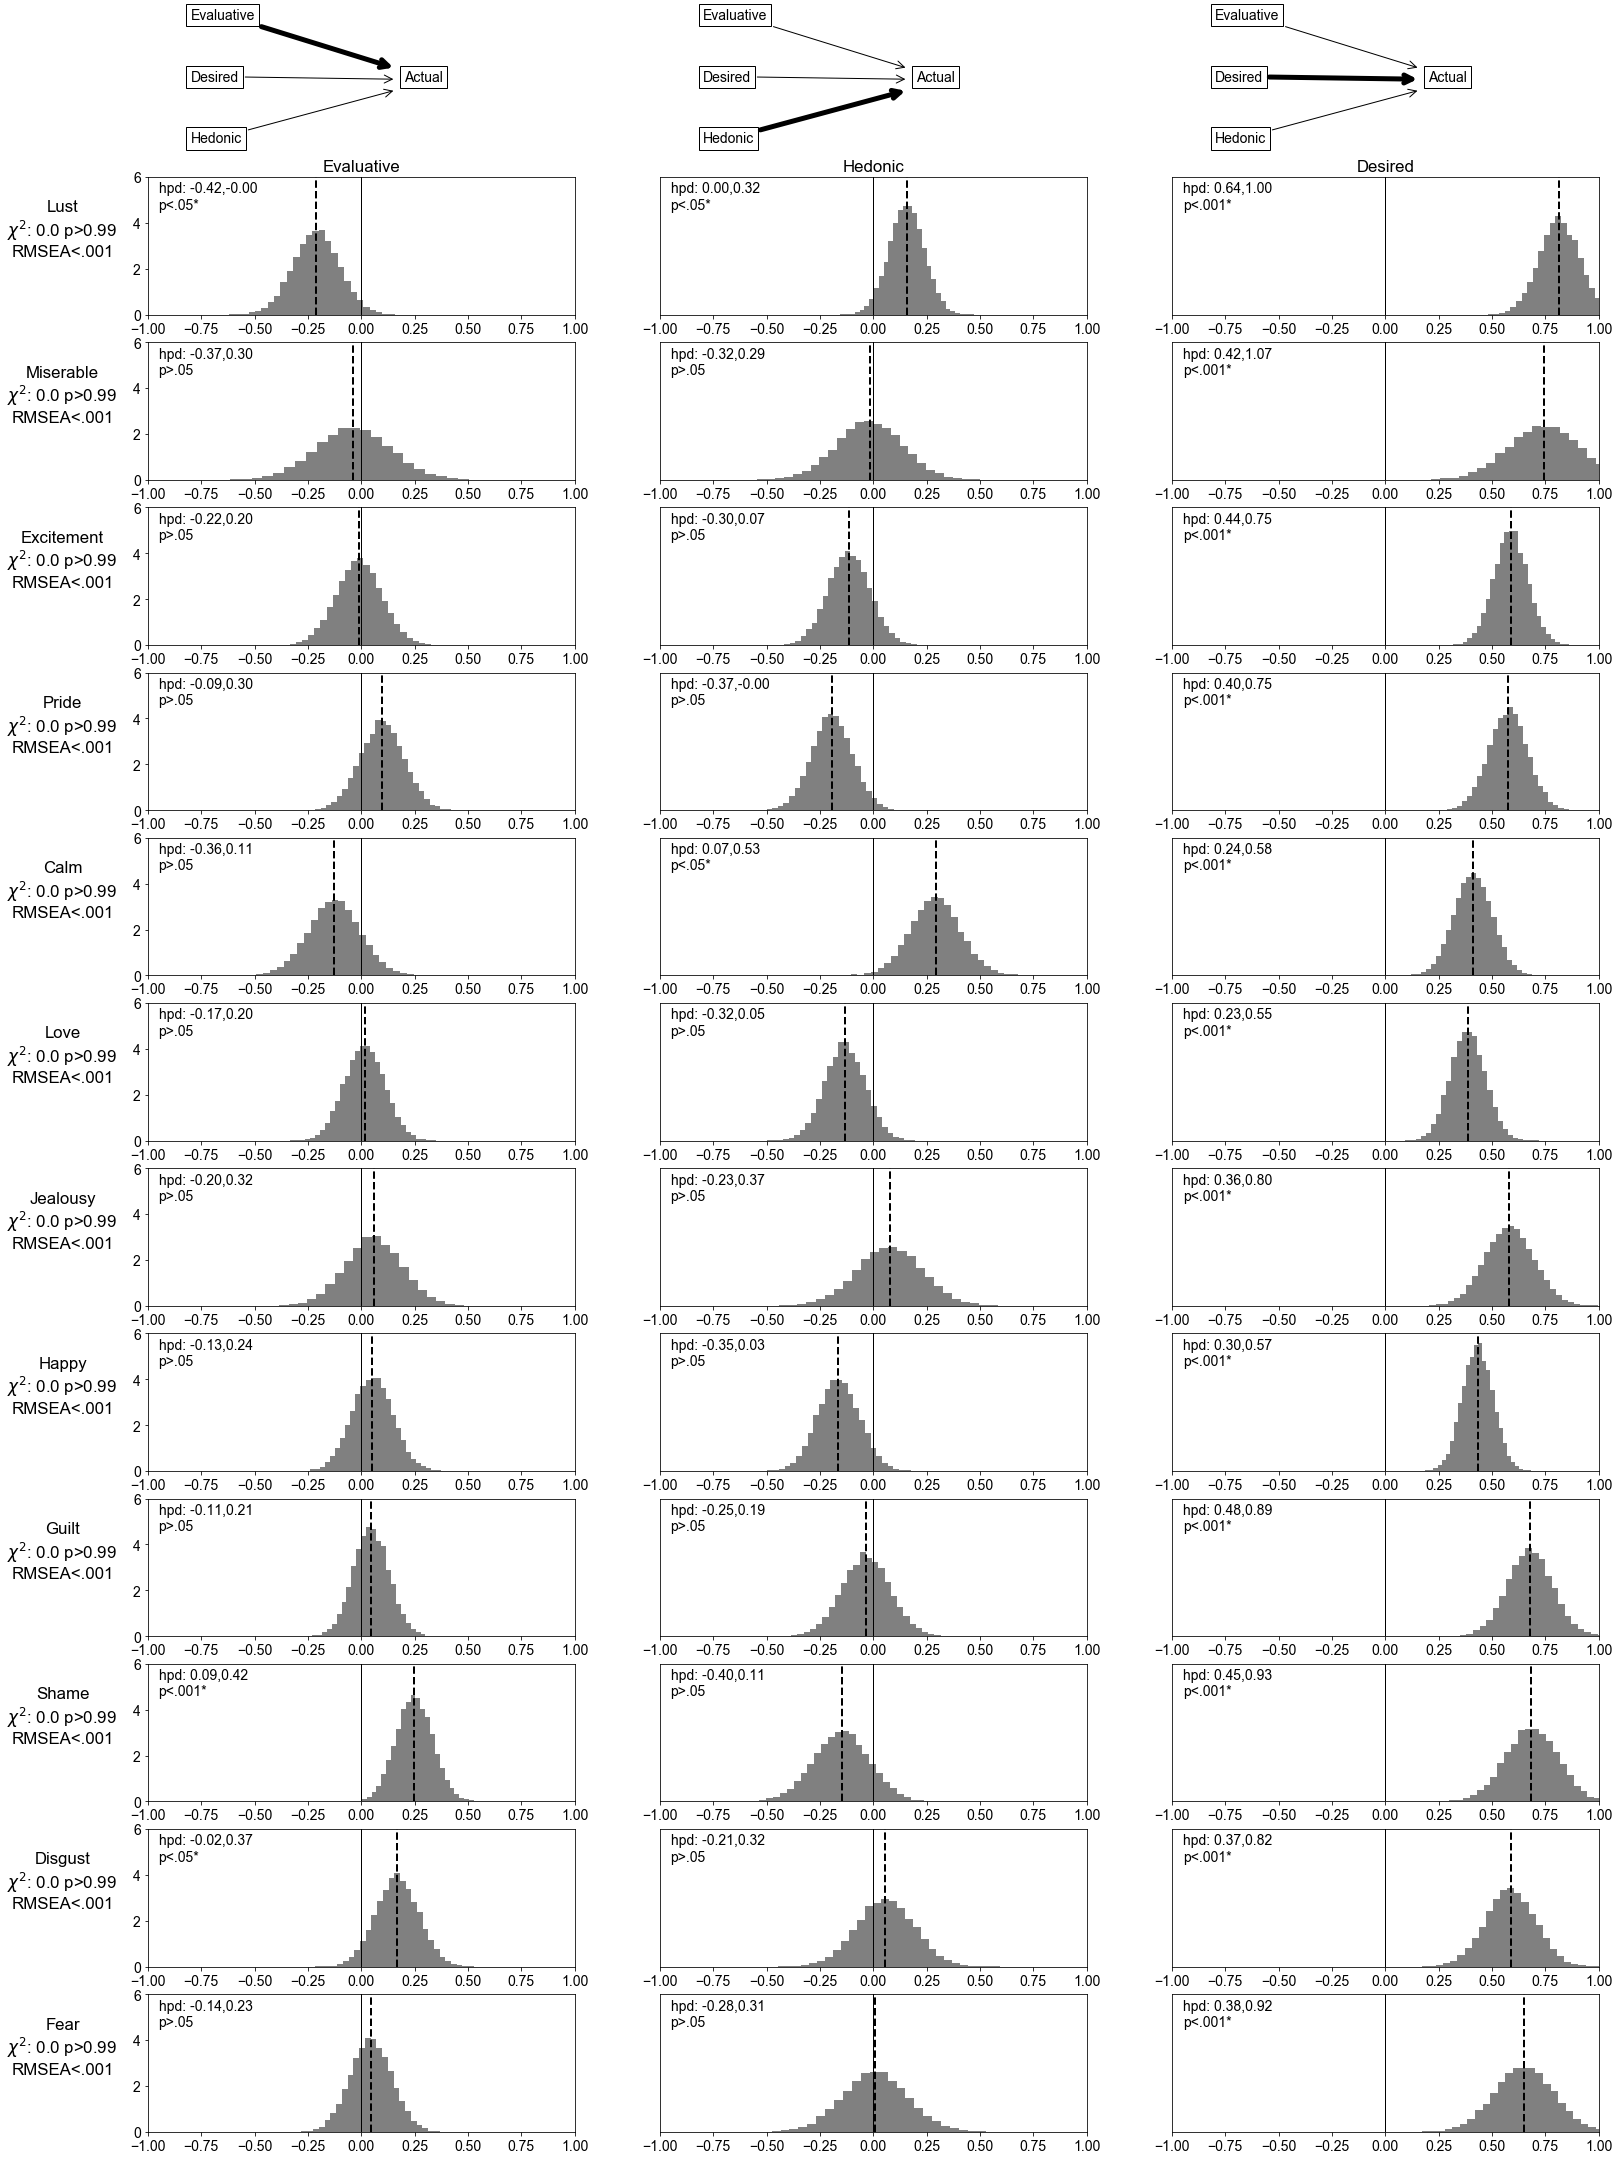

In [28]:
bayes_good_betas_means = [np.mean(predict_desired_trace['good'][:,i]) for i in range(len(emo_concepts_regression))]
sorted_index = pd.DataFrame(data={'means':bayes_good_betas_means}).sort_values('means', ascending=False).index.values
emotion_order_plot = np.array(emo_concepts_regression)[sorted_index]


plt.rcParams.update({'font.size': 14,
                    'font.family':'Arial'})

fig,axes =plt.subplots(13,3, figsize=(26,39))
valuation_columns = ['Evaluative','Hedonic','Desired']

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

for ax, col in zip(axes[1], valuation_columns):
    ax.set_title(col)

ylabel_strings = GetAllYLabelStrings(emotion_order_plot, FlatModelDf)
for ax, label in zip(axes[1:,0], ylabel_strings):
    ax.set_ylabel(label, rotation=0, labelpad=10, size='large')
    ax.yaxis.set_label_coords(-0.2,.4)

line_color ='black'
hist_color = 'grey'

DrawFlatDiagram (axes[0,0], 1,5,1)
DrawFlatDiagram (axes[0,1], 5,1,1)
DrawFlatDiagram (axes[0,2], 1,1,5)


for idx in range(1,13):
    emotion_idx = sorted_index[idx-1]
    emotion = emo_concepts_regression[emotion_idx]
    
    row = FlatModelDf.loc[TwoLevelModeldf['emotion']==emotion]
    
    beta_good= row.B_Val_Ideal.values[0]
    beta_good_p = row.P_Val_Ideal.values[0]
    beta_good_bayes = flat_model_trace['good'][:,emotion_idx]
    
    beta_pleasant = row.B_Val_Pleasant.values[0]
    beta_pleasant_p = row.P_Val_Pleasant.values[0]
    beta_pleasant_bayes = flat_model_trace['pleasant'][:,emotion_idx]
    
    
    beta_ideal =row.B_Val_Good.values[0]
    beta_ideal_p = row.P_Val_Good.values[0]
    beta_ideal_bayes = flat_model_trace['ideal'][:,emotion_idx]
    
    #good plot
    MakeIndividualPlot(axes[idx,0],
                       beta_good_bayes,
                       beta_good,
                      beta_good_p,
                      hist_color,
                      line_color,
                      [0,2,4,6])

    
    #pleasant plot
    MakeIndividualPlot(axes[idx,1],
                       beta_pleasant_bayes,
                       beta_pleasant,
                      beta_pleasant_p,
                      hist_color,
                      line_color,
                      [])
    
    #ideal plot
    MakeIndividualPlot(axes[idx,2],
                       beta_ideal_bayes,
                       beta_ideal,
                      beta_ideal_p,
                      hist_color,
                      line_color,
                      [])

plt.savefig('flatModel_fig.eps', dps=1200)

<Figure size 432x288 with 0 Axes>